In [1]:
import numpy as np

full_data = np.load('./full_data.npy', allow_pickle=True)
X_train_event, X_test_event, X_train_obj, X_test_obj, y_train, y_test = full_data

In [2]:
import tensorflow as tf
from tensorflow import keras

2022-02-01 10:18:02.501939: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
# GPU memory management

all_devices = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", all_devices)
physical_devices=tf.config.experimental.list_physical_devices('GPU')
gpus= tf.config.experimental.list_physical_devices('GPU')
for i in range(0,all_devices):
    tf.config.experimental.set_memory_growth(gpus[i], True)

mirrored_strategy = tf.distribute.MirroredStrategy(devices=[f"/GPU:{GPU_id}" for GPU_id in range (0,6)])

Num GPUs Available:  6
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5')


2022-01-31 15:18:40.282391: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-31 15:18:40.285567: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-31 15:18:41.229999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-01-31 15:18:41.232617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-01-31 15:18:41.235133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:5f:00.0 name: Tesla T4 computeCapability: 

In [3]:
# Build NN
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model, Sequential

# RNN part
obj_input = Input(shape=X_train_obj.shape[1:])
lstm1 = LSTM(32)(obj_input)
# lstm_output = Dense(1, activation="sigmoid")(lstm1)

event_input = Input(shape=X_train_event.shape[1])
x = Concatenate()([lstm1, event_input])
# Feedforward part
hidden1 = Dense(100, activation='selu', kernel_initializer='lecun_normal')(x)
hidden2 = Dense(100, activation='selu', kernel_initializer='lecun_normal')(hidden1)
hidden3 = Dense(100, activation='selu', kernel_initializer='lecun_normal')(hidden2)
out = Dense(1, activation="sigmoid")(hidden3)
# event_output = Dense(1, activation='sigmoid')(hidden3)
# out_combined = Concatenate()([lstm_output, event_output])
# out = Dense(1, activation="sigmoid")(out_combined)
combined_model = Model(inputs=[obj_input, event_input], outputs=out)
combined_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=[keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])
print(combined_model.summary())


2022-01-31 18:40:59.940343: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-31 18:40:59.940991: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/grid.cern.ch/centos7-ui-4.0.3-1_umd4v3/usr/lib64:/cvmfs/grid.cern.ch/centos7-ui-4.0.3-1_umd4v3/usr/lib:/cvmfs/grid.cern.ch/centos7-ui-4.0.3-1_umd4v3/usr/lib64:/cvmfs/grid.cern.ch/centos7-ui-4.0.3-1_umd4v3/usr/lib
2022-01-31 18:40:59.941016: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-31 18:40:59.941036: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sc01.dice.priv): /proc/driver/nvidia/version does not exist
2022-01-31 18:40:59.941300: I tensorflow/core/platform/cpu_feature_guard.cc:

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 8)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32)           5248        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 43)           0           lstm[0][0]                       
                                                                 input_2[0][0]                

In [3]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Flatten, LayerNormalization, BatchNormalization
from tensorflow.keras.models import Model, Sequential

obj_input = Input(shape=X_train_obj.shape[1:])
lstm1 = LSTM(32)(obj_input)
ln = LayerNormalization()(lstm1)

event_input = Input(shape=X_train_event.shape[1])
hidden1 = Dense(100, activation='selu', kernel_initializer='lecun_normal')(event_input)
bn = BatchNormalization()(hidden1)
x = Concatenate()([ln, bn])
hidden2 = Dense(100, activation='selu', kernel_initializer='lecun_normal')(x)
bn2 = BatchNormalization()(hidden2)
hidden3 = Dense(100, activation='selu', kernel_initializer='lecun_normal')(bn2)
bn3 = BatchNormalization()(hidden3)
out = Dense(1, activation="sigmoid")(bn3)
noah_model = Model(inputs=[obj_input, event_input], outputs=out)
noah_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=[keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])
print(noah_model.summary())

2022-02-01 10:19:51.578221: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-01 10:19:51.617840: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-01 10:19:52.196495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-02-01 10:19:52.196529: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-01 10:19:53.004970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-01 10:19:53.005075: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 8)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32)           5248        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          1200        input_2[0][0]                    
______________________________________________________________________________________________

In [4]:
# Imbalanced dataset so want to adjusts weights of signal and background training examples
tot = len(y_train)
pos = np.sum(y_train == 1)
neg = tot - pos
print(f'Total training samples:  {tot}\npositives:  {pos}\nnegatives:  {neg}')

# weight positives more than negatives
weight_for_0 = (1 / neg) * (tot / 2.0)
weight_for_1 = (1 / pos) * (tot / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f'Postive weight:  {weight_for_1} \nNegative weight:  {weight_for_0}')

Total training samples:  327177
positives:  79444
negatives:  247733
Postive weight:  2.0591674638739237 
Negative weight:  0.660341981084474


In [5]:
noah_model.fit([X_train_obj, X_train_event], y_train, epochs=6, class_weight=class_weight, validation_data=([X_test_obj, X_test_event], y_test))

2022-02-01 10:20:23.441897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-01 10:20:23.568823: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1996355000 Hz


Epoch 1/6


2022-02-01 10:20:26.047503: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-01 10:20:29.431618: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


10225/10225 [==============================] - 96s 8ms/step - loss: 0.5412 - auc: 0.8022 - precision: 0.4582 - recall: 0.7313 - val_loss: 0.4926 - val_auc: 0.8221 - val_precision: 0.5314 - val_recall: 0.6715
Epoch 2/6
10225/10225 [==============================] - 59s 6ms/step - loss: 0.5231 - auc: 0.8166 - precision: 0.4807 - recall: 0.7314 - val_loss: 0.5172 - val_auc: 0.8278 - val_precision: 0.4812 - val_recall: 0.7614
Epoch 3/6
10225/10225 [==============================] - 52s 5ms/step - loss: 0.5176 - auc: 0.8221 - precision: 0.4891 - recall: 0.7380 - val_loss: 0.5093 - val_auc: 0.8310 - val_precision: 0.4953 - val_recall: 0.7454
Epoch 4/6
10225/10225 [==============================] - 60s 6ms/step - loss: 0.5137 - auc: 0.8246 - precision: 0.4929 - recall: 0.7364 - val_loss: 0.5142 - val_auc: 0.8316 - val_precision: 0.4757 - val_recall: 0.7766
Epoch 5/6
10225/10225 [==============================] - 60s 6ms/step - loss: 0.5113 - auc: 0.8268 - precision: 0.4946 - recall: 0.7393 - 

In [22]:
history = combined_model.fit([X_train_obj, X_train_event], y_train, epochs=20, class_weight=class_weight, validation_data=([X_test_obj, X_test_event], y_test))

Epoch 1/20
10225/10225 [==============================] - 47s 4ms/step - loss: 0.5420 - auc_1: 0.8018 - precision_7: 0.4596 - recall_7: 0.7285 - val_loss: 0.5144 - val_auc_1: 0.8232 - val_precision_7: 0.5006 - val_recall_7: 0.7239
Epoch 2/20
10225/10225 [==============================] - 40s 4ms/step - loss: 0.5171 - auc_1: 0.8225 - precision_7: 0.4884 - recall_7: 0.7361 - val_loss: 0.5268 - val_auc_1: 0.8254 - val_precision_7: 0.4713 - val_recall_7: 0.7720
Epoch 3/20
10225/10225 [==============================] - 44s 4ms/step - loss: 0.5119 - auc_1: 0.8254 - precision_7: 0.4916 - recall_7: 0.7347 - val_loss: 0.4897 - val_auc_1: 0.8264 - val_precision_7: 0.5181 - val_recall_7: 0.7041
Epoch 4/20
10225/10225 [==============================] - 43s 4ms/step - loss: 0.5101 - auc_1: 0.8277 - precision_7: 0.4982 - recall_7: 0.7379 - val_loss: 0.4927 - val_auc_1: 0.8281 - val_precision_7: 0.5074 - val_recall_7: 0.7258
Epoch 5/20
10225/10225 [==============================] - 45s 4ms/step - los

In [23]:
combined_model.save('./RNN_model')

INFO:tensorflow:Assets written to: ./RNN_model/assets


INFO:tensorflow:Assets written to: ./RNN_model/assets


In [6]:
import os

checkpoint_path = "./combined_RNN_checkpoints"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [5]:
combined_model.load_weights("./Combined_RNN_checkpoints")

In [6]:
# Model predictions

y_pred = combined_model.predict([X_test_obj, X_test_event])

y_pred

2022-01-31 18:41:14.873451: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-31 18:41:14.886912: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2394025000 Hz


array([[0.08180419],
       [0.3863551 ],
       [0.35954225],
       ...,
       [0.06682679],
       [0.58045447],
       [0.95815146]], dtype=float32)

In [7]:
y_pred = y_pred.reshape(y_test.shape)

In [8]:
# Analysis

thresholds = np.arange(0.05, 1, 0.001)
FP = np.zeros(len(thresholds))
FN = np.zeros(len(thresholds))
TP = np.zeros(len(thresholds))
TN = np.zeros(len(thresholds))

for idx, threshold in enumerate(thresholds):
    FP[idx] = ((y_test == 0) & (y_pred >= threshold)).sum()
    FN[idx] = ((y_test == 1) & (y_pred < threshold)).sum()
    TP[idx] = ((y_test == 1) & (y_pred >= threshold)).sum()
    TN[idx] = ((y_test == 0) & (y_pred < threshold)).sum()

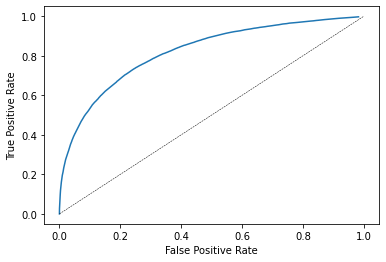

In [9]:
import matplotlib.pyplot as plt

# ROC curve
tpr = TP/(np.sum(y_test))
fpr = FP/(np.sum(y_test==0))
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', linewidth=0.5, color='k')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [10]:
# Get threshold for ~ 0.05 fpr 

threshold = thresholds[np.abs(fpr-0.05).argmin()]
idx = np.abs(fpr-0.05).argmin()
idx

750

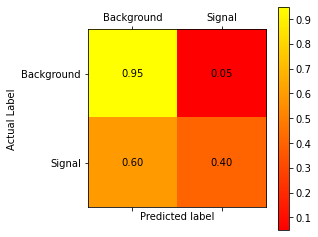

In [19]:
# plt.matshow([[TN[-1], FP[-1]], [FN[-1], TP[-1]]], cmap='binary')
conf_mat = [[1-fpr[750], fpr[750]], [1-tpr[750], tpr[750]]]
plt.matshow(conf_mat, cmap='autumn')
for (x, y), value in np.ndenumerate(conf_mat):
    plt.text(y, x, f"{value:.2f}", va="center", ha="center")
plt.xlabel('Predicted label')
plt.ylabel('Actual Label')
plt.xticks([0,1], labels=['Background', 'Signal'])
plt.yticks([0,1], labels=['Background', 'Signal'])
plt.colorbar()
plt.show()

In [15]:
print(TN[-1], FP[-1], FN[-1], TP[-1])

0.7568677792041079 0.0003178678403325387 0.23824194632923773 0.0045724066263219025


In [20]:
# Significance

# load xs weights
test_weights, train_weights = np.load('weights.npy', allow_pickle=True)

# Get predictions for combined dataset
y_pred_train = combined_model.predict([X_train_obj, X_train_event])
y_total = np.concatenate([y_test, y_train])
y_pred_train = y_pred_train.reshape(y_train.shape)
y_pred_total = np.concatenate([y_pred, y_pred_train])
y_pred_total


array([0.08180419, 0.3863551 , 0.35954225, ..., 0.8090347 , 0.16087896,
       0.9728327 ], dtype=float32)

In [21]:
total_weights = np.concatenate([test_weights, train_weights])

In [26]:
total_weights

array([ 1.0588149e-06,  1.0588149e-06,  1.0588149e-06, ...,
        1.0588149e-06, -1.0588149e-06,  8.6958615e-08], dtype=float32)

In [35]:
significance = np.zeros(len(thresholds), dtype=float)
lum = 140e3

for idx, threshold in enumerate(thresholds):
    sg = (lum * total_weights * ((y_pred_total >= threshold) & (y_total == 1))).sum()
    bg = (lum * total_weights * ((y_pred_total >= threshold) & (y_total == 0))).sum()
    significance[idx] = sg/np.sqrt(bg)
    print(f"Signal events surviving cut:  {sg}\nBackground events surviving cut:  {bg}\nCorresponding siginificance is:  {significance[idx]}")

Signal events surviving cut:  11257.619140625
Background events surviving cut:  34420.11328125
Corresponding siginificance is:  60.67927932739258
Signal events surviving cut:  11256.5693359375
Background events surviving cut:  34364.08984375
Corresponding siginificance is:  60.72305679321289
Signal events surviving cut:  11254.7666015625
Background events surviving cut:  34302.8203125
Corresponding siginificance is:  60.76752853393555
Signal events surviving cut:  11252.80078125
Background events surviving cut:  34239.4140625
Corresponding siginificance is:  60.81314468383789
Signal events surviving cut:  11251.009765625
Background events surviving cut:  34163.58984375
Corresponding siginificance is:  60.87090301513672
Signal events surviving cut:  11249.9453125
Background events surviving cut:  34086.8984375
Corresponding siginificance is:  60.93357849121094
Signal events surviving cut:  11247.83203125
Background events surviving cut:  34011.7109375
Corresponding siginificance is:  60

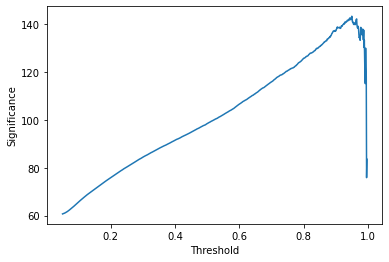

In [40]:
plt.plot(thresholds[:-2], significance[:-2])
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.show()

In [41]:
print(f"Best threshold is {thresholds[np.argmax(significance[:-2])]}")

Best threshold is 0.9500000000000008


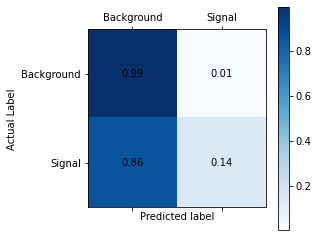

In [47]:
idx = np.argmax(significance[:-2])

conf_mat = [[1-fpr[idx], fpr[idx]], [1-tpr[idx], tpr[idx]]]
plt.matshow(conf_mat, cmap='Blues')
for (x, y), value in np.ndenumerate(conf_mat):
    plt.text(y, x, f"{value:.2f}", va="center", ha="center")
plt.xlabel('Predicted label')
plt.ylabel('Actual Label')
plt.xticks([0,1], labels=['Background', 'Signal'])
plt.yticks([0,1], labels=['Background', 'Signal'])
plt.colorbar()
plt.show()

In [48]:
sg = (lum * total_weights * ((y_pred_total >= threshold) & (y_total == 1))).sum()
bg = (lum * total_weights * ((y_pred_total >= threshold) & (y_total == 0))).sum()
significance[idx] = sg/np.sqrt(bg)
print(f"Signal events surviving cut:  {sg}\nBackground events surviving cut:  {bg}\nCorresponding siginificance is:  {significance[idx]}")

Signal events surviving cut:  1.3456755876541138
Background events surviving cut:  0.0
Corresponding siginificance is:  inf


In [49]:
np.sqrt(bg)

0.0